[View in Colaboratory](https://colab.research.google.com/github/XinyueZ/tf/blob/master/ipynb/price_rooms_estimator_clean_data.ipynb)

# This case is a ML model about the linear relationship between "average housing area" and "price per housing area".

In [0]:
import tensorflow as tf
from tensorflow.python.data import Dataset
import sklearn
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

In [0]:
STEPS = 1000  # Steps of train loop. 
PERIODS = 20
STEPS_PER_PERIOD = STEPS / PERIODS
LEARNING_RATE = 0.000001
BINS = 150

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

In [123]:
source = pd.read_csv("https://dl.dropbox.com/s/e2tcsgbcp2in5h5/price_rooms_area.tsv", sep="\t")
source.head()

,PRICE,ROOMS,AREA,OBJECTCAT,MARKETINGTYPE
0,5,0,249,Sonstiges Büro-/Praxisobjekt,Miete
1,595000,9,440,Besondere Immobilie,Kauf
2,199000,6,"135,75",Stadthaus,Kauf
3,269000,9,"203,57",Stadthaus,Kauf
4,562,3,"63,15",Etagenwohnung,Miete


In [124]:
source.describe()

,PRICE,ROOMS,AREA,OBJECTCAT,MARKETINGTYPE
count,299322,299322,299322,299322,299322
unique,33403,171,24271,124,5
top,250000,0,0,Wohnung,Kauf
freq,1549,71482,16285,52536,204503


In [125]:
_object_category = source["OBJECTCAT"]
object_category = list()
fn = lambda: [x for x in _object_category if not (x in object_category or object_category.append(x))]
fn()
object_category

['Sonstiges Büro-/Praxisobjekt',
 'Besondere Immobilie',
 'Stadthaus',
 'Etagenwohnung',
 'Doppelhaushälfte',
 'Sonstiges Haus',
 'Bürofläche',
 'Wohnung',
 'Verkaufsfläche',
 'Wohngrundstück',
 'Einfamilienhaus',
 'Dachgeschosswohnung',
 'Erdgeschosswohnung',
 'Landhaus',
 'Apartment',
 'Zweifamilienhaus',
 'Bürohaus',
 'Ladenlokal',
 'Gastronomie',
 'Bauernhaus',
 'Villa',
 'Bungalow',
 'Garage',
 'Sonstige Land- und Forstwirtschaft',
 'Penthouse',
 'Mehrfamilienhaus',
 'Maisonette',
 'Praxisfläche',
 'Stellplatz',
 'Haus',
 'Reihenmittelhaus',
 'Tiefgaragenstellplatz',
 'Zimmer',
 'Rustico',
 'Praxishaus',
 'Wohnanlage',
 'Schloss',
 'Reihenendhaus',
 'Lagerfläche',
 'Halle',
 'Wohngemeinschaft',
 'Sonstiges Renditeobjekt',
 'Geschäftshaus',
 'Werkstatt',
 'Wohn- und Geschäftshaus',
 'Architektenhaus',
 'Gewerbegrundstück',
 'Einzelhandelsladen',
 'Hotel/Pension',
 'Praxis',
 'Kiosk',
 'Restaurant',
 'Produktionsfläche',
 'Loft/Atelier',
 'Ausstellungsfläche',
 'Café',
 'Gewerbe all

# Clean the data-source
- Remove rows containing *null*
- Remove rows containing *N/A*
- Add New data columns: "Average area per room", "Average room per area" , "per area price".
- Clean new added columns

In [0]:
def clean_data(source):
  df = source
  
  # Remove null rows
  df = df[pd.notnull(df["PRICE"])]
  df = df[pd.notnull(df["ROOMS"])]
  df = df[pd.notnull(df["AREA"])]
  
  # Remove useless columns
  df = df[~df["MARKETINGTYPE"].isin(["Miete"])]
  df = df.drop(["MARKETINGTYPE"], axis=1)
  cat = df[["OBJECTCAT"]]
  df = df.drop(["OBJECTCAT"], axis=1)
  
  # Convert all strings to numeric
  df = df.apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',',''), errors='coerce'))
  df = pd.concat([df, cat], axis=1)

  # Remove rows containing a "0", i.e price = 0 or rooms = 0 
  df = df[(df[["PRICE", "ROOMS","AREA"]] > 0).all(axis=1)]
 
  # Remove rows containing N/A 
  df = df[pd.notna(df["PRICE"])]
  df = df[pd.notna(df["ROOMS"])]
  df = df[pd.notna(df["AREA"])]
  df = df[pd.notna(df["OBJECTCAT"])]

  # Insert new column of "price of pro-area"
  df.insert(1, "PRICE_PRO_AREA", df["PRICE"] / df["AREA"]) 
  df = df[~(df["PRICE_PRO_AREA"] < 5)]
  #df["PRICE_PRO_AREA"] = df["PRICE_PRO_AREA"] / 1000 #Scale -1000 for easy demo.
  df["PRICE_PRO_AREA"] = np.log(df["PRICE_PRO_AREA"])
  df = df[pd.notnull(df["PRICE_PRO_AREA"])]
  df = df[pd.notna(df["PRICE_PRO_AREA"])]
    
  # Insert new column of "area of each room"
  df.insert(4, "AREA_PRO_ROOM", df["AREA"] / df["ROOMS"]) 
  df = df[~(df["AREA_PRO_ROOM"] < 1)]
  df["AREA_PRO_ROOM"] = np.log(df["AREA_PRO_ROOM"])
  df = df[pd.notnull(df["AREA_PRO_ROOM"])]
  df = df[pd.notna(df["AREA_PRO_ROOM"])]
  
  # Insert new column of "room of each area"
  df.insert(5, "ROOM_PRO_AREA", df["ROOMS"] / df["AREA"]) 
  df["ROOM_PRO_AREA"] = np.log(df["ROOM_PRO_AREA"])
  df = df[pd.notnull(df["ROOM_PRO_AREA"])]
  df = df[pd.notna(df["ROOM_PRO_AREA"])]
  
  return df

In [0]:
df = clean_data(source)

In [128]:
df.head()

,PRICE,PRICE_PRO_AREA,ROOMS,AREA,AREA_PRO_ROOM,ROOM_PRO_AREA,OBJECTCAT
1,595000,7.209542,9,440,3.889550,-3.889550,Besondere Immobilie
2,199000,2.685075,6,13575,7.724226,-7.724226,Stadthaus
3,269000,2.581287,9,20357,7.723956,-7.723956,Stadthaus
5,299000,7.666556,5,140,3.332205,-3.332205,Doppelhaushälfte
6,685000,7.497003,8,380,3.860730,-3.860730,Sonstiges Haus


In [129]:
df.describe()

,PRICE,PRICE_PRO_AREA,ROOMS,AREA,AREA_PRO_ROOM,ROOM_PRO_AREA
count,1.627420e+05,162742.000000,162742.000000,162742.000000,162742.000000,162742.000000
mean,9.698981e+05,6.878684,6.454314,1775.837958,4.085284,-4.085284
std,1.980465e+08,1.640987,9.938712,6026.061500,1.688530,1.688530
min,3.000000e+02,1.611324,1.000000,1.000000,0.000000,-11.526029
25%,1.460000e+05,6.596168,3.000000,98.000000,3.227725,-3.958907
50%,2.590000e+05,7.403077,4.000000,150.000000,3.455265,-3.455265
75%,4.259000e+05,7.876968,6.000000,346.000000,3.958907,-3.227725
max,7.987979e+10,20.960654,540.000000,841053.000000,11.526029,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f735282d278>]],
      dtype=object)

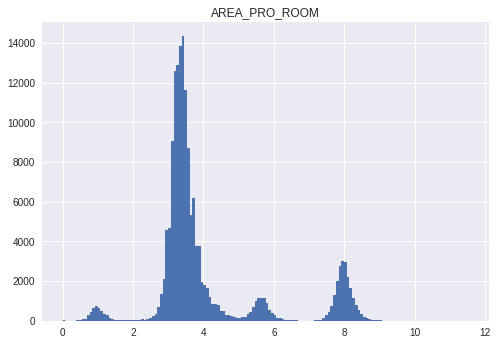

In [130]:
df.hist("AREA_PRO_ROOM", bins=BINS)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73527fa3c8>]],
      dtype=object)

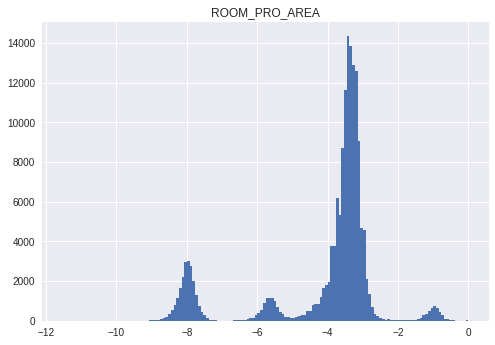

In [131]:
df.hist("ROOM_PRO_AREA", bins=BINS)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73524d9fd0>]],
      dtype=object)

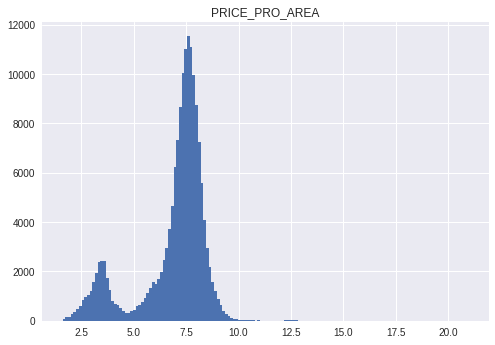

In [132]:
df.hist("PRICE_PRO_AREA", bins=BINS)

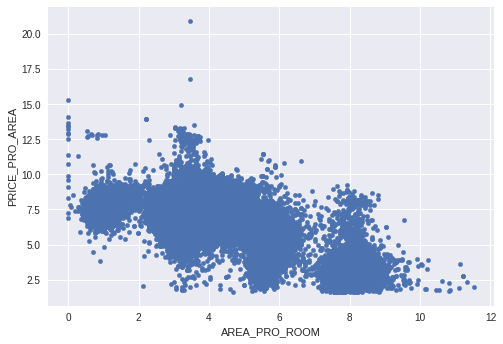

In [133]:
df.plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

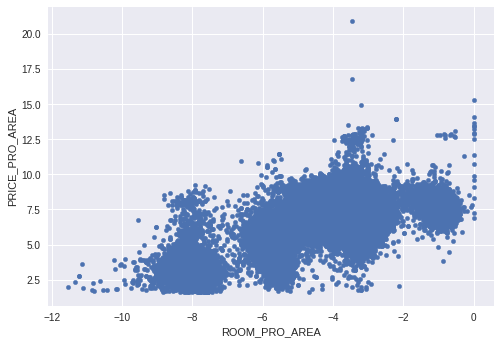

In [134]:
df.plot.scatter(x='ROOM_PRO_AREA', y='PRICE_PRO_AREA')

In [0]:
def make_dataset_and_labels_and_class_num(df, label_name):
  """This method will prepare da, labels for train, evaluation, test.
     Args:
      df: DataFrame format of datasource.
      label_name: The name of column in datasource which will be as target for train.
     Return: 
       Tuple of (ds_train, ds_eval, ds_test, label_train, label_eval, label_test)
      
  """
  target_label_col = label_name
   
  random_seed = None
  np.random.seed(random_seed)
  
  ds_train = df.sample(frac=0.7, random_state=random_seed)
  label_train = ds_train[[target_label_col]]
  
  ds_rest = df.drop(ds_train.index)
  ds_rest = ds_rest.copy()
  
  ds_eval = ds_rest.sample(frac=0.7, random_state=random_seed)
  label_eval = ds_eval[[target_label_col]]
  
  ds_test = ds_rest.drop(ds_eval.index)
  label_test = ds_test[[target_label_col]]
  
  return ds_train[["AREA_PRO_ROOM", "ROOM_PRO_AREA", "OBJECTCAT"]], ds_eval[["AREA_PRO_ROOM", "ROOM_PRO_AREA", "OBJECTCAT"]], ds_test[["AREA_PRO_ROOM", "ROOM_PRO_AREA", "OBJECTCAT"]], label_train, label_eval, label_test

In [0]:
x_train, x_eval, x_test, y_train, y_eval, y_test = make_dataset_and_labels_and_class_num(df, "PRICE_PRO_AREA")

In [137]:
x_train.describe()

,AREA_PRO_ROOM,ROOM_PRO_AREA
count,113919.000000,113919.000000
mean,4.088331,-4.088331
std,1.688997,1.688997
min,0.000000,-11.526029
25%,3.228826,-3.962716
50%,3.455265,-3.455265
75%,3.962716,-3.228826
max,11.526029,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7352240c88>]],
      dtype=object)

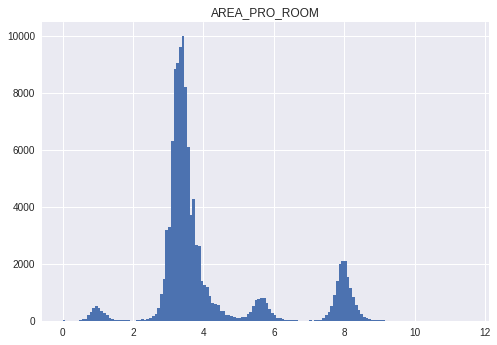

In [138]:
x_train.hist("AREA_PRO_ROOM", bins = BINS)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73521b5080>]],
      dtype=object)

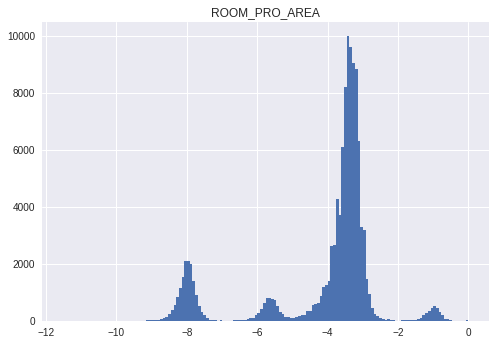

In [139]:
x_train.hist("ROOM_PRO_AREA", bins = BINS)

In [140]:
y_train.describe()

,PRICE_PRO_AREA
count,113919.000000
mean,6.875589
std,1.642083
min,1.611324
25%,6.591086
50%,7.402452
75%,7.873702
max,20.960654


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7351fa8828>]],
      dtype=object)

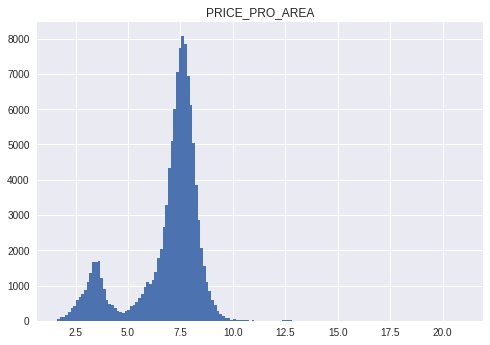

In [141]:
y_train.hist("PRICE_PRO_AREA", bins=BINS)

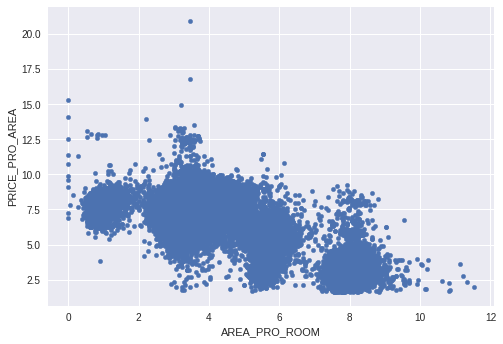

In [142]:
pd.concat([x_train, y_train], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA') 

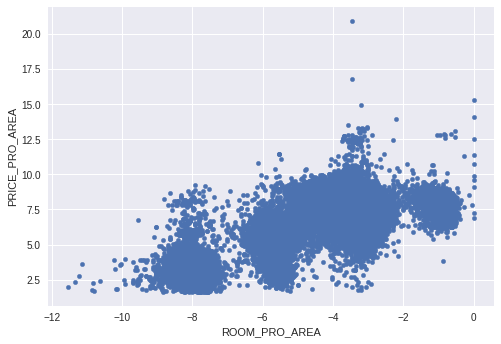

In [143]:
pd.concat([x_train, y_train], axis=1).plot.scatter(x='ROOM_PRO_AREA', y='PRICE_PRO_AREA') 

In [144]:
x_eval.describe()

,AREA_PRO_ROOM,ROOM_PRO_AREA
count,34176.000000,34176.000000
mean,4.081480,-4.081480
std,1.691293,1.691293
min,0.000000,-11.228677
25%,3.218876,-3.936716
50%,3.453157,-3.453157
75%,3.936716,-3.218876
max,11.228677,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7352095f98>]],
      dtype=object)

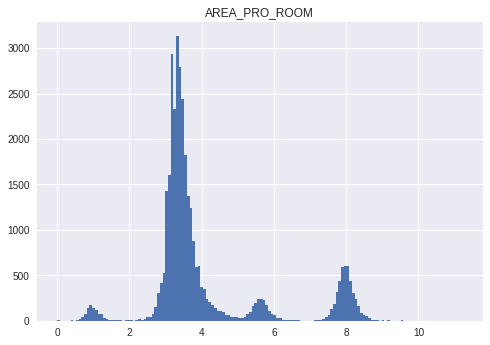

In [145]:
x_eval.hist("AREA_PRO_ROOM", bins = BINS)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7351b7f5f8>]],
      dtype=object)

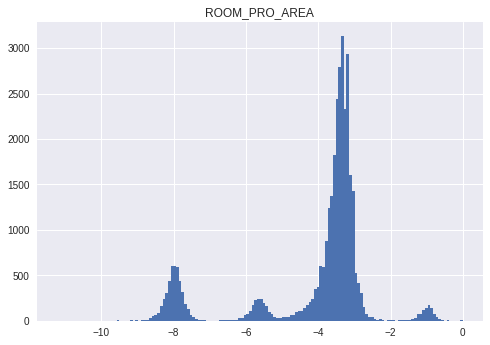

In [146]:
x_eval.hist("ROOM_PRO_AREA", bins = BINS)

In [147]:
y_eval.describe()

,PRICE_PRO_AREA
count,34176.000000
mean,6.883138
std,1.640376
min,1.622692
25%,6.600776
50%,7.404294
75%,7.884201
max,13.920871


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73519414a8>]],
      dtype=object)

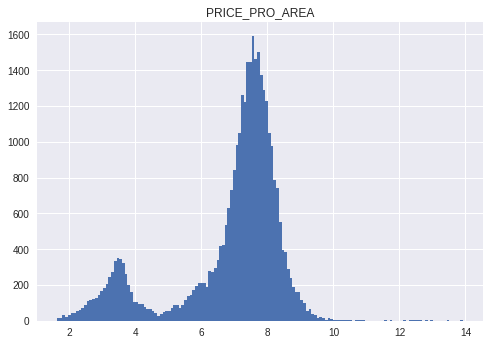

In [148]:
y_eval.hist("PRICE_PRO_AREA", bins=BINS)

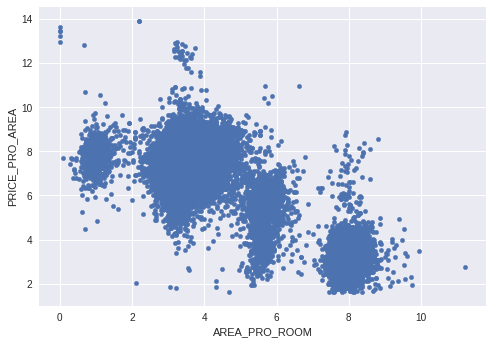

In [149]:
pd.concat([x_eval, y_eval], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

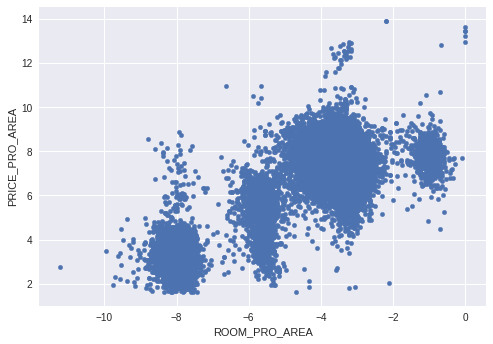

In [150]:
pd.concat([x_eval, y_eval], axis=1).plot.scatter(x='ROOM_PRO_AREA', y='PRICE_PRO_AREA')

In [151]:
x_test.describe()

,AREA_PRO_ROOM,ROOM_PRO_AREA
count,14647.000000,14647.000000
mean,4.070458,-4.070458
std,1.678436,1.678436
min,0.000000,-11.104310
25%,3.232121,-3.951244
50%,3.449988,-3.449988
75%,3.951244,-3.232121
max,11.104310,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7351612ef0>]],
      dtype=object)

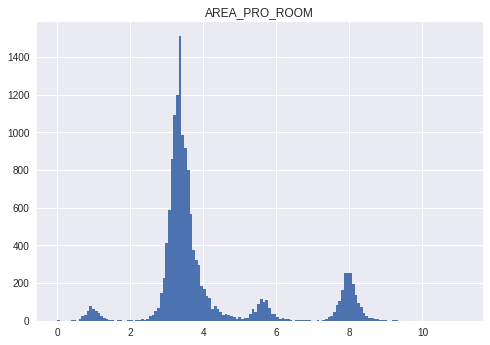

In [152]:
x_test.hist("AREA_PRO_ROOM", bins=BINS)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73514ac8d0>]],
      dtype=object)

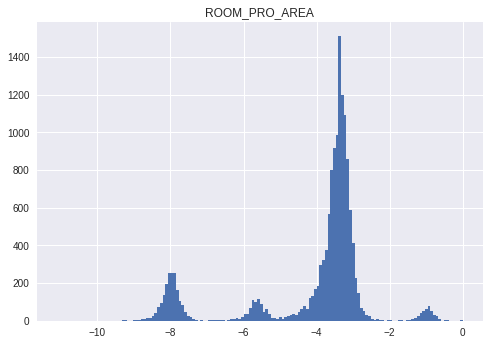

In [153]:
x_test.hist("ROOM_PRO_AREA", bins=BINS)

In [154]:
y_test.describe()

,PRICE_PRO_AREA
count,14647.000000
mean,6.892361
std,1.633879
min,1.626584
25%,6.612321
50%,7.403169
75%,7.880216
max,13.285947


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7351392908>]],
      dtype=object)

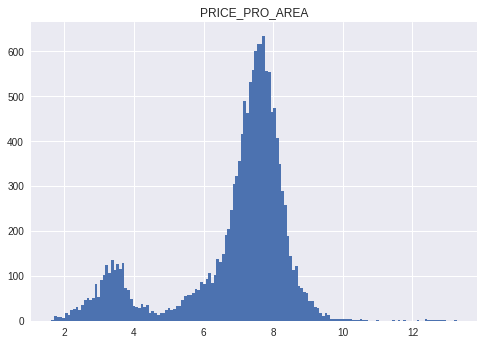

In [155]:
y_test.hist("PRICE_PRO_AREA", bins=BINS)

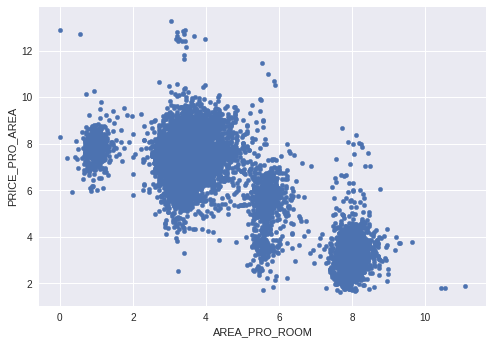

In [156]:
pd.concat([x_test, y_test], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

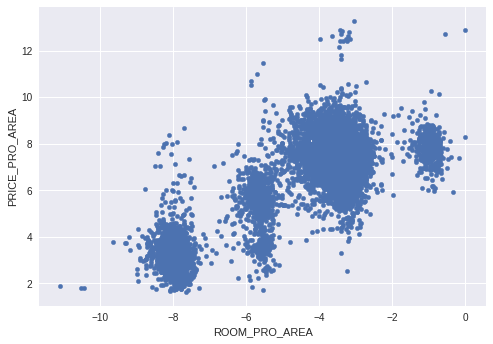

In [157]:
pd.concat([x_test, y_test], axis=1).plot.scatter(x='ROOM_PRO_AREA', y='PRICE_PRO_AREA')

In [158]:
x_train.head()

,AREA_PRO_ROOM,ROOM_PRO_AREA,OBJECTCAT
250633,3.178054,-3.178054,Etagenwohnung
71996,3.178054,-3.178054,Wohnung
116561,3.860730,-3.860730,Mehrfamilienhaus
281677,3.518980,-3.518980,Penthouse
194054,3.355735,-3.355735,Sonstiges Haus


In [159]:
x_eval.head()

,AREA_PRO_ROOM,ROOM_PRO_AREA,OBJECTCAT
171642,3.282521,-3.282521,Mehrfamilienhaus
241456,8.088255,-8.088255,Wohnung
126501,8.338575,-8.338575,Doppelhaushälfte
40369,3.555348,-3.555348,Einfamilienhaus
192180,3.459466,-3.459466,Sonstiges Haus


In [160]:
x_test.head()

,AREA_PRO_ROOM,ROOM_PRO_AREA,OBJECTCAT
31,3.344039,-3.344039,Etagenwohnung
78,3.401197,-3.401197,Apartment
89,8.296235,-8.296235,Einfamilienhaus
99,3.367296,-3.367296,Dachgeschosswohnung
100,3.178054,-3.178054,Bauernhaus


In [161]:
y_train.head()

,PRICE_PRO_AREA
250633,7.207860
71996,7.459403
116561,5.827396
281677,8.680823
194054,6.770896


In [162]:
y_eval.head()

,PRICE_PRO_AREA
171642,7.606250
241456,3.663562
126501,3.648253
40369,7.728164
192180,9.083079


In [163]:
y_test.head()

,PRICE_PRO_AREA
31,6.472437
78,7.995194
89,2.789363
99,6.930484
100,7.680945


In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
 
    # Construct a dataset, and configure batching/repeating
    features = {key:np.array(value) for key,value in dict(features).items()} 
  
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
train_input_fn = lambda: input_fn(x_train, y_train)

In [0]:
train_predict_input_fn = lambda: input_fn(x_train, y_train, num_epochs=1, shuffle=False)

In [0]:
eval_predict_input_fn = lambda: input_fn(x_eval, y_eval, num_epochs=1, shuffle=False)

In [0]:
test_predict_input_fun = lambda: input_fn(x_test, y_test, num_epochs=1, shuffle=False)

In [0]:
feature_cols = [
  tf.feature_column.numeric_column("AREA_PRO_ROOM"),
  tf.feature_column.numeric_column("ROOM_PRO_AREA"),
  tf.feature_column.categorical_column_with_vocabulary_list(
        key="OBJECTCAT",
        vocabulary_list=object_category)
]

In [0]:
train_optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_optimizer = tf.contrib.estimator.clip_gradients_by_norm(train_optimizer, 5.0)

In [171]:
model = tf.estimator.LinearRegressor(
    feature_columns = feature_cols,
    optimizer = train_optimizer
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjmmt745n', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7351029550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [172]:
for period in range(0, PERIODS):
  model.train(input_fn=train_input_fn, steps=STEPS)
  #train_predict = model.predict(input_fn=train_predict_input_fn)
  #eval_predict = model.predict(input_fn=eval_predict_input_fn)
  print("-" * 100)
  metrics_train = model.evaluate(steps=STEPS, input_fn=train_predict_input_fn)
  metrics_eval = model.evaluate(steps=STEPS, input_fn=eval_predict_input_fn) 
  print("-" * 100)
  
  #train_predict = np.array([item['predictions'][0] for item in train_predict])
  #eval_predict = np.array([item['predictions'][0] for item in eval_predict])
  
  # Compute loss for train and evaluation
  #train_rmse = math.sqrt(
  #      sklearn.metrics.mean_squared_error(train_predict, y_train))
  #eval_rmse = math.sqrt(
  #      sklearn.metrics.mean_squared_error(eval_predict, y_eval))
  train_rmse = np.sqrt(metrics_train['average_loss'])
  eval_rmse = np.sqrt(metrics_eval['average_loss'])
  
  print("*" * 100)
  print("*Period[rmse training] %02d : %0.2f" % (period, train_rmse))
  print("*Period[rmse eval] %02d : %0.2f" % (period, eval_rmse))  
  print("*" * 100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjmmt745n/model.ckpt.
INFO:tensorflow:loss = 63.499023, step = 0
INFO:tensorflow:global_step/sec: 103.1
INFO:tensorflow:loss = 68.45578, step = 100 (0.976 sec)
INFO:tensorflow:global_step/sec: 215.104
INFO:tensorflow:loss = 46.74269, step = 200 (0.463 sec)
INFO:tensorflow:global_step/sec: 217.909
INFO:tensorflow:loss = 49.538036, step = 300 (0.460 sec)
INFO:tensorflow:global_step/sec: 203.043
INFO:tensorflow:loss = 83.46112, step = 400 (0.492 sec)
INFO:tensorflow:global_step/sec: 193
INFO:tensorflow:loss = 65.38566, step = 500 (0.517 sec)
INFO:tensorflow:global_step/sec: 206.397
INFO:tensorflow:loss = 35.089542, step = 600 (0.486 sec)
INFO:tensorflow:global_step/sec: 213.976
INFO:tensorflow:loss = 55.

In [173]:
test_predict = model.predict(input_fn=test_predict_input_fun)
print("-" * 100)
metrics_test = model.evaluate(steps=STEPS, input_fn=test_predict_input_fun)
print("-" * 100)
test_predict = np.array([item['predictions'][0] for item in test_predict])  
#test_rmse = math.sqrt(
#        sklearn.metrics.mean_squared_error(test_predict, y_test))
test_rmse = np.sqrt(metrics_test['average_loss'])
print("*" * 100)
print("*Final[rmse test] %02d : %0.2f" % (period, test_rmse))
print("*" * 100)

----------------------------------------------------------------------------------------------------
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-26-20:39:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpjmmt745n/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-08-26-20:39:26
INFO:tensorflow:Saving dict for global step 20000: average_loss = 42.903667, global_step = 20000, label/mean = 6.860667, loss = 42.

In [0]:
test_predict = np.array([item for item in test_predict])

In [175]:
test_predict

array([0.47393826, 0.47988915, 1.1466031 , ..., 0.44266066, 0.487654  ,
       0.4794043 ], dtype=float32)